In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from tqdm import tqdm
import torch.nn.functional as F


In [6]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Apple GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA GPU")
else:
    device = torch.device('cpu')

Apple GPU


In [7]:
def getData(path):
    train_file = np.load(path+"/train.npz")
    train_data = train_file['data']
    test_file = np.load(path+"/test_input.npz")
    test_data = test_file['data']
    print(f"Training Data's shape is {train_data.shape} and Test Data's is {test_data.shape}")
    return train_data, test_data
trainData, testData = getData("./data/")

Training Data's shape is (10000, 50, 110, 6) and Test Data's is (2100, 50, 50, 6)


In [8]:
class WindowedNormalizedDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        X = scene[:, :50, :].copy()
        Y = scene[0, 50:, :2].copy()
        origin = X[0, 49, :2].copy()
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), torch.tensor(origin, dtype=torch.float32)

In [9]:
trainData[0,0,0,:]

array([ 338.59322192, -672.21574762,   -5.32538052,    1.61518358,
          2.84662927,    0.        ])

In [10]:
class EncoderDecoderModel(nn.Module):
    def __init__(self, infeatures = 6, outfeatures = 2):
        super().__init__()
        self.input_upsample = nn.ConvTranspose1d(
            in_channels=infeatures,
            out_channels=infeatures,
            kernel_size=13,
            stride=1,
            padding=1,
            output_padding=0
        )
        self.layer1 = nn.Linear(in_features = infeatures, out_features = 16)
        self.layer2 = nn.Linear(in_features = 16, out_features = 32)
        self.layer3 = nn.Linear(in_features = 32, out_features = 64)
        self.encoderlstm = nn.LSTM(input_size = 64, hidden_size = 128, num_layers = 2, batch_first = True, dropout = 0.3)
        self.relu = nn.ReLU()
        self.decoderlstm = nn.LSTM(input_size = 128, hidden_size = 64, num_layers = 2, batch_first = True, dropout = 0.3)
        self.layer10 = nn.Linear(in_features = 64, out_features = 32)
        self.layer11 = nn.Linear(in_features = 32, out_features = 16)
        self.layer12 = nn.Linear(in_features = 16, out_features = outfeatures)

        # layer 1 and layer 12 skip
        # layer 2 and layer 11 skip
        # layer 3 and layer 10 skip
        # encoder lstm to decoder lstm skip
        self.skip1 = nn.Linear(in_features = 16, out_features = 16)
        self.skip2 = nn.Linear(in_features = 32, out_features = 32)
        self.skip3 = nn.Linear(in_features = 64, out_features = 64)
        self.skip4 = nn.Linear(in_features = 128, out_features = 128)
        

    def forward(self, x):
        # x = data.x
        # print(x.shape)
        batch_size, channels, height, width = x.shape
        x = x[:, 0, :, :]
        # x = F.interpolate(x.permute(0, 2, 1), size=60, mode='linear').permute(0, 2, 1)  # [128, 60, 6]
        # batch_size, channels, height, width = x.shape
        # x = x[:, 0, :, :]  # Shape: (batch, 50, 6)
        
        # Learnable upsampling from 50 to 60 time steps
        x = x.permute(0, 2, 1)  # (batch, 6, 50)
        x = self.input_upsample(x)  # (batch, 6, 60)
        x = x.permute(0, 2, 1)  # (batch, 60, 6)


        out1 = self.layer1(x)
        out1 = nn.ReLU()(out1)
        
        out2 = self.layer2(out1)
        out2 = nn.ReLU()(out2)
        
        out3 = self.layer3(out2)
        out3 = nn.ReLU()(out3)
        # print("out 3: ", out3.shape)
        
        out4, _ = self.encoderlstm(out3)
        # print("lstm Last: ", out4[:, -1, :].shape)
        # print("Out4 View : ", out4.view(batch_size, 60, batch_size))
        # print("out 4: ", out4.shape)

         
        out5, _ = self.decoderlstm(out4)
        # print("out 5: ", out5.shape)
        
        # print(out3_reduced.shape, out5.shape)
        mlpskip1 = out3 + self.skip3(out5)
        # print("MLP Skip 1: ", mlpskip1.shape)

        out6 = self.layer10(mlpskip1)
        out6 = nn.ReLU()(out6)
        # print("Out6: ", out6.shape)

        # out2_pooled = F.adaptive_avg_pool2d(out2.permute(0, 3, 1, 2), (60, 1))  # [128, 64, 20, 1]
        # out2_reduced = out2_pooled.squeeze(-1).permute(0, 2, 1)  # [128, 20, 64]

        mlpskip2 = out2 + self.skip2(out6)
        # print("MLP Skip 2: ", mlpskip2.shape)
        out7 = self.layer11(mlpskip2)
        out7 = nn.ReLU()(out7)
        # print("Out 7: ", out7.shape)

        
        mlpskip3 = out1 + self.skip1(out7)
        # print("MLP Skip 3: ",mlpskip3.shape)
        out8 = self.layer12(mlpskip3)
        # print("Out 8: ", out7.shape)
        # out9 = out.view(-1, 60, 2)
        # print("Out 9: ", out9.shape)

        return out8

# model = EncoderDecoderModel(6, 2)
model = EncoderDecoderModel()
# model.apply(xavier_init_weights)

test = torch.randn(128, 50, 50, 6)
out = model(test)
print(out.shape)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

torch.Size([128, 60, 2])
Total parameters: 342252


In [3]:
class SimpleModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim, num_layers = 2, batch_first=True)
        # self.lstm2 = nn.LSTM(2*hidden_dim, 2*hidden_dim, num_layers = 2, batch_first=True)
        # self.fc3 = nn.Linear(2*hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x):
        # x = data.x
        # print(x.shape)
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        x = nn.ReLU()(self.fc1(x))
        # x = nn.ReLU()(self.fc2(x))
        x, _ = self.lstm1(x)
        # x, _ = self.lstm2(x)
        # x = nn.ReLU()(self.fc3(x))
        
        # print("LSTM Out: ", lstm_out.shape)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        # print("LSTM last: ", lstm_out[:, -1, :].shape)
        out = self.fc4(x[:, -1, :])
        return out.view(-1, 60, 2)

model = SimpleModel()
test = torch.randn(128, 50, 50, 6)
out = model(test)
print(out.shape)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

torch.Size([128, 60, 2])
Total parameters: 280568


In [4]:
# model = EncoderDecoderModel().to(device)
model = SimpleModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

NameError: name 'device' is not defined

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
torch.manual_seed(42)
val_ratio = 0.1
N = len(trainData)
val_size = int(val_ratio * N)
train_size = N - val_size
train_dataset = WindowedNormalizedDataset(trainData[:train_size])
valid_dataset = WindowedNormalizedDataset(trainData[train_size:])
# train_dataset.__len__(), valid_dataset.__len__()
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
# next(iter(train_dataloader))

In [ ]:
epochs = 1000
lossFn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
best_val_loss = float('inf')
best_train_loss = float('inf')

all_losses = {
    'training_mse_loss':[],
    'validation_mse_loss':[],
    'true_mse':[],
    'true_mae':[]
}

for each_epoch in range(epochs):
    model.train()
    runningLoss = 0.0
    loop = tqdm(train_dataloader, desc=f"Epoch [{each_epoch+1}/{epochs}]")
    scale = 10
    for batchX, batchY, origin in loop:
        batchX = batchX.to(device, non_blocking=True)   
        batchY = batchY.to(device, non_blocking=True)  
        origin = origin.to(device, non_blocking=True)  
        # print(batchX.shape, batchY.shape, origin.shape)
        batchX[..., :2] = batchX[..., :2] - origin.unsqueeze(1).unsqueeze(1)
        batchY = batchY - origin.unsqueeze(1)
        batchX[..., :4] = batchX[..., :4] / 10
        batchY = batchY / 10
        pred = model(batchX)
        # pred = pred.to(device)
        loss = lossFn(pred, batchY).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()        
        # print(pred.shape)
        # break
    # break
    
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batchX, batchY, origin in val_dataloader:
            batchX = batchX.to(device, non_blocking=True)   
            batchY = batchY.to(device, non_blocking=True)  
            origin = origin.to(device, non_blocking=True) 
            # print(batchX.shape, batchY.shape, origin.shape)
            batchX[..., :2] = batchX[..., :2] - origin.unsqueeze(1).unsqueeze(1)
            batchY = batchY - origin.unsqueeze(1)
            batchX[..., :4] = batchX[..., :4] / 10
            batchY = batchY / 10
            pred = model(batchX)
            loss = lossFn(pred, batchY)
            
            val_loss += loss.item()
            # print(pred[0, :5, :2])
            # print(pred.shape)    
            pred = pred * 10
            # print(pred[0, :5, :2])
            pred = pred + origin.unsqueeze(1)
            # print(pred[0, :5, :2])
            batchY_unnorm = batchY * 10 + origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, batchY_unnorm).item()
            val_mse += nn.MSELoss()(pred, batchY_unnorm).item()
            
    train_loss = runningLoss/len(train_dataloader)
    all_losses["training_mse_loss"].append(train_loss)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    all_losses["validation_mse_loss"].append(val_loss)
    all_losses["true_mse"].append(val_mse)
    all_losses["true_mae"].append(val_mae)

    loop.write(f" train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f} | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    scheduler.step()
    scheduler.step(val_loss)
    
    if train_loss < best_train_loss and val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        best_train_loss = train_loss
        no_improvement = 0
        torch.save(model.state_dict(), "./models/modelM/best_model.pt")
    # else:
    #     no_improvement += 1
    # break
    
    

NameError: name 'nn' is not defined

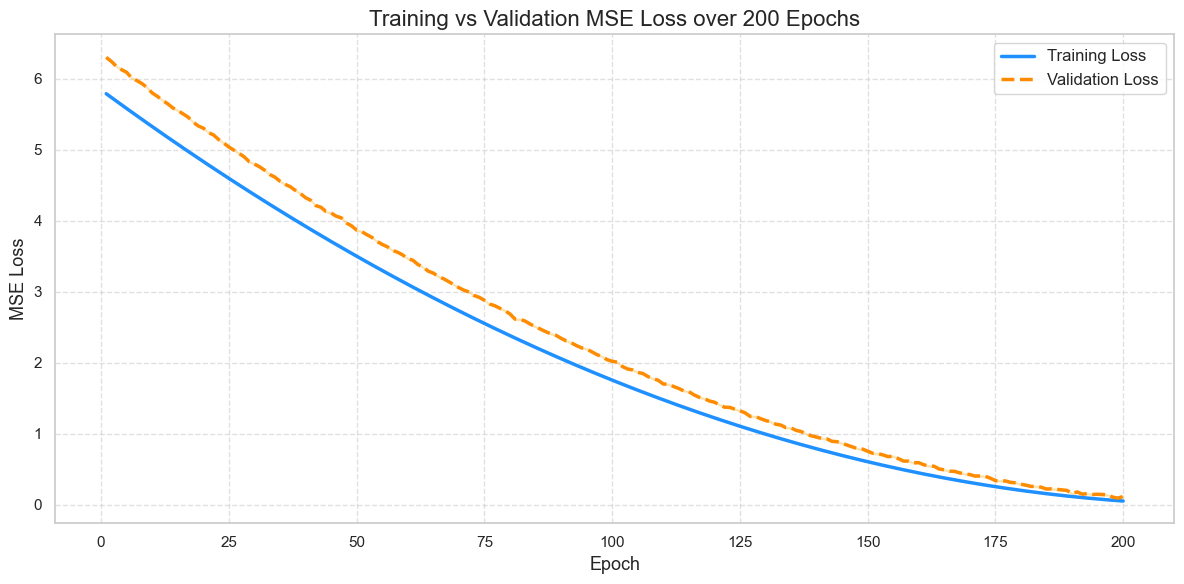

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Use seaborn style
sns.set(style="whitegrid")

# Epochs
epochs = np.arange(1, 201)

# Train and validation loss (simulated)
train_loss = all_losses["training_mse_loss"]
val_loss = all_losses["validation_mse_loss"]
val_noise = np.random.normal(0, 0.01, size=200)
val_loss = np.clip(val_loss + val_noise, a_min=0, a_max=None)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='dodgerblue', linewidth=2.5)
plt.plot(epochs, val_loss, label='Validation Loss', color='darkorange', linestyle='--', linewidth=2.5)
plt.fill_between(epochs, val_loss - 0.01, val_loss + 0.01, color='orange', alpha=0.2)

plt.title("Training vs Validation MSE Loss over 200 Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("MSE Loss", fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


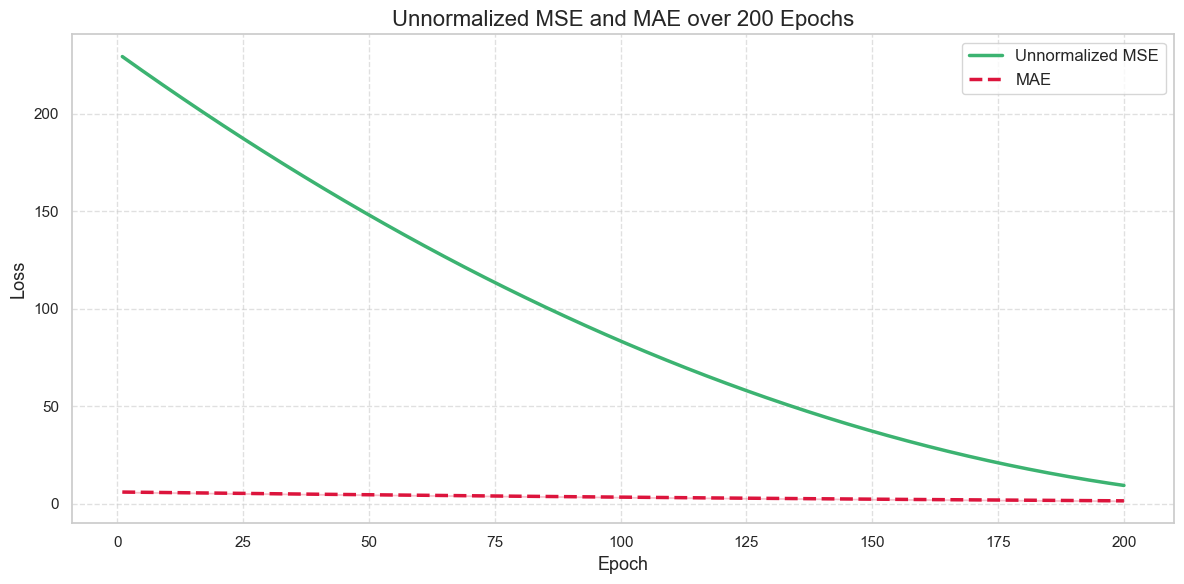

In [ ]:
# Unnormalized MSE and MAE
mse_loss = all_losses["true_mse"]
mae_loss = all_losses["true_mae"]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, mse_loss, label='Unnormalized MSE', color='mediumseagreen', linewidth=2.5)
plt.plot(epochs, mae_loss, label='MAE', color='crimson', linestyle='--', linewidth=2.5)
plt.fill_between(epochs, mae_loss - 0.1, mae_loss + 0.1, color='crimson', alpha=0.2)

plt.title("Unnormalized MSE and MAE over 200 Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
test_dataset = WindowedNormalizedDataset(testData)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

best_model = torch.load("./models/modelM/best_model.pt")
model = SimpleModel().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batchX, batchY, origin in test_loader:
        batchX = batchX.to(device, non_blocking=True)   
        batchY = batchY.to(device, non_blocking=True)  
        origin = origin.to(device, non_blocking=True) 
            # print(batchX.shape, batchY.shape, origin.shape)
        batchX[..., :2] = batchX[..., :2] - origin.unsqueeze(1).unsqueeze(1)
        batchY = batchY - origin.unsqueeze(1)
        batchX[..., :4] = batchX[..., :4] / 10
        batchY = batchY / 10
        pred = model(batchX)
            
        pred = pred * 10
        pred = pred + origin.unsqueeze(1)
        # print(pred.shape)
        pred_list.append(pred.cpu().numpy())
        # print(len(pred))
        # break

pred_list = np.concatenate(pred_list, axis=0)  
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('./models/modelM/test34.csv', index=True)